In [20]:
import sys
sys.path.insert(0,'..')

# Compute Embeddings 

In [21]:
import pandas as pd
from src import embeddings

df = pd.read_csv('../output/armando_headline_prediction.csv')
headlines = list(df['headline'])

In [22]:
headlines[:20]

['\nLike Downton Abbey? Well, There’s Another Drama About A Rich Family But PBS Is Scared To Show It\n',
 '\nWell I Gotta Give It To Him, That\'s A Pretty Good Reason To Stop "Curing" Gay People\n',
 "\nYet Another Anti-Gay Guy Saying Gays Should… Er, Well, That's Kinda Amazing.\n",
 " 'Be The Change You Want To See.' It's An Inspiring Quote, But In Action, It's Life Altering. ",
 " 'This Land Was Made For You And Me' — Or Was It?",
 ' A Bunch Of Middle Schoolers Actually Raised Their Hands And Volunteered For Something?!',
 ' A Famous Actor Dies And Leaves Behind This Important Message I’d Never Seen Before Now',
 ' A Greedy Old Power Company Decided To Pick A Fight With Some Young Organized 20-Somethings. Whoops.',
 ' A Perspective On George Zimmerman That Every Person Should Hear',
 ' A Video About Hate That You’ll Love To Hate Watch',
 ' After Being Confronted With Racism, This Group Of Kids Say What I Wish Everyone Thought ',
 ' Could You Go 100 Days Without Food? These Men Have.\

In [23]:
hl_embeddings = embeddings.bert(headlines)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


Batches:   0%|          | 0/231 [00:00<?, ?it/s]

In [24]:
df.describe()

,ctr
count,59021.000000
mean,0.013331
std,0.011223
min,0.000000
25%,0.005976
50%,0.010131
75%,0.016957
max,0.148913


<AxesSubplot:ylabel='Density'>

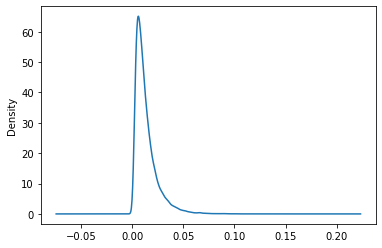

In [25]:
# before normalization
df['ctr'].plot.density()

In [26]:
# normalize df['ctr']
mu = df['ctr'].mean()
sigma = df['ctr'].std()

df['ctr']=(df['ctr']-mu)/sigma
mu, sigma

(0.013330962313144663, 0.01122255879149954)

<AxesSubplot:ylabel='Density'>

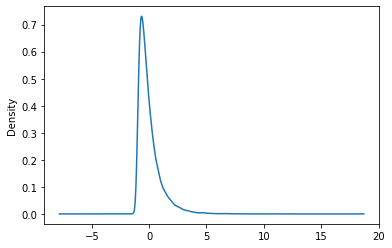

In [27]:
# After normalization
df['ctr'].plot.density()

In [6]:
# import pickle
# import numpy as np

# hle_fname = '../output/hl_embeddings_heading_prediction.pkl'
# hl_embeddings = pickle.load(open(hle_fname, "rb"))
# hl_embeddings = np.array(hl_embeddings)
# hl_embeddings.shape

(65362, 384)

In [30]:
X = np.array(hl_embeddings)
y = df['ctr'].to_numpy()

In [31]:
X.shape, y.shape

((59021, 384), (59021,))

# Predict 

In [32]:
import torch
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

class PackagesDataset(torch.utils.data.Dataset):
    """
    Prepare the Packages dataset for regression
    """

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


class MLP(nn.Module):
    """
      Multilayer Perceptron for regression.
    """

    def __init__(self, in_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        """
          Forward pass
        """
        return self.layers(x)

In [42]:
NB_EPOCHS = 30
# Set fixed random number seed
torch.manual_seed(42)

# Load Packages dataset
# X, y = load_packages()

# Prepare Packages dataset
dataset = PackagesDataset(X, y)

# Split Packages dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create trainloader object
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)

# Create testloader object
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=1)

# Initialize the MLP
mlp = MLP(in_size=X.shape[1])

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)


losses = {'train': [], 'test': []}
epochs = range(NB_EPOCHS)


def train(epoch):
     # Print epoch
    print(f'Starting epoch {epoch + 1}')

    mlp.train()
    
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(trainloader)
    
    losses['train'].append(current_loss)
    
    print('Train Loss: %.3f'%(current_loss))

    
def test(epoch):
    mlp.eval()

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(testloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(testloader)
    
    losses['test'].append(current_loss)
    
    print('Test Loss: %.3f'%(current_loss))

# Run the training loop
for epoch in epochs:
    train(epoch)
    test(epoch)

Starting epoch 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train Loss: 0.944
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Test Loss: 0.857
Starting epoch 2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variab

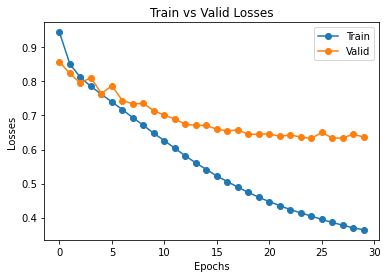

In [45]:
import matplotlib.pyplot as plt

plt.plot(losses['train'], '-o')
plt.plot(losses['test'], '-o')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [44]:
min(losses['test'])

0.6325511279258322

# Examples

In [14]:
headlines = [
    'Parliament Square protesters clash with police on Bonfire Night',
    "Sarah",
    "Brexit: 'Serious consequences' if Article 16 triggered, warns EU",
    "Michael Vaughan will not present BBC show after Azeem Rafiq racism allegations",
    "10 As",
    "I wanted to",
    "Paris explained to 5 Live's Naga Munchetty how the decline in his mental health affected their relationship.",
    "Feeling lucky?",
]

In [15]:
hl_embeddings = embeddings.bert(headlines)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
X = np.array(hl_embeddings)

mlp(torch.tensor(X))*sigma + mu

tensor([[0.0149],
        [0.0146],
        [0.0153],
        [0.0146],
        [0.0146],
        [0.0147],
        [0.0149],
        [0.0134]], grad_fn=<AddBackward0>)

In [17]:
# torch.save(mlp.state_dict(), '../output/mlp_headline_prediction_500_epochs.pt')